# **Engage2Value: From Clicks to Conversions** [MLP Project T22025]

# Description

The goal of this competition is to predict a customer’s purchase value based on their multi-session behavior across digital touchpoints.

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings('ignore')        

/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv


# Goal: Predict customer purchase values based on multi-session behavior


# LIBRARY IMPORTS

Imported all essential libraries, preprocessing tools, and tree-based models (XGBoost, LightGBM, RandomForest) for building and evaluating ML pipelines.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pickle
import re
import warnings
import json
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import r2_score

# Models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# DATA LOADING AND INITIAL EXPLORATION

Loaded training and test datasets from competition files with basic shape and column info display.

In [3]:
def load_data():
    """Load and return train and test datasets"""
    # Load the datasets
    train_data = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv')
    test_data = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv')
    
    print("=== DATA LOADING SUMMARY ===")
    print(f"Training data shape: {train_data.shape}")
    print(f"Test data shape: {test_data.shape}")
    print(f"Training columns: {list(train_data.columns)}")
    
    return train_data, test_data

# Load data
train_df, test_df = load_data()

=== DATA LOADING SUMMARY ===
Training data shape: (116023, 52)
Test data shape: (29006, 51)
Training columns: ['trafficSource.isTrueDirect', 'purchaseValue', 'browser', 'device.screenResolution', 'trafficSource.adContent', 'trafficSource.keyword', 'screenSize', 'geoCluster', 'trafficSource.adwordsClickInfo.slot', 'device.mobileDeviceBranding', 'device.mobileInputSelector', 'userId', 'trafficSource.campaign', 'device.mobileDeviceMarketingName', 'geoNetwork.networkDomain', 'gclIdPresent', 'device.operatingSystemVersion', 'sessionNumber', 'device.flashVersion', 'geoNetwork.region', 'trafficSource', 'totals.visits', 'geoNetwork.networkLocation', 'sessionId', 'os', 'geoNetwork.subContinent', 'trafficSource.medium', 'trafficSource.adwordsClickInfo.isVideoAd', 'browserMajor', 'locationCountry', 'device.browserSize', 'trafficSource.adwordsClickInfo.adNetworkType', 'socialEngagementType', 'geoNetwork.city', 'trafficSource.adwordsClickInfo.page', 'geoNetwork.metro', 'pageViews', 'locationZone', 

# EXPLORATORY DATA ANALYSIS (EDA)

Performed comprehensive EDA to analyze shape, types, missing values, demo placeholders, target distribution, and high-cardinality features.

In [4]:
def comprehensive_eda(df, target_col='purchaseValue'):
    """Perform comprehensive exploratory data analysis"""
    
    print("=== EXPLORATORY DATA ANALYSIS ===")
    
    # Basic info
    print(f"\n1. Dataset Info:")
    print(f"Shape: {df.shape}")
    
    # Data types
    print(f"\n2. Data Types:")
    print(df.dtypes.value_counts())
    
    # Missing values analysis
    print(f"\n3. Missing Values Analysis:")
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing_Count': missing_data,
        'Missing_Percent': missing_percent
    }).sort_values('Missing_Count', ascending=False)
    
    print("Top features with missing values:")
    print(missing_df[missing_df['Missing_Count'] > 0].head(10))
    
    # Identify "not available in demo dataset" columns
    demo_unavailable = []
    for col in df.select_dtypes(include=['object']).columns:
        if df[col].nunique() == 1 and 'not available in demo dataset' in df[col].values:
            demo_unavailable.append(col)
    
    print(f"\n4. Demo Dataset Unavailable Features ({len(demo_unavailable)}):")
    print(demo_unavailable)
    
    # Basic statistics
    print(f"\n5. Numerical Features Statistics:")
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    if len(numerical_cols) > 0:
        print(df[numerical_cols].describe())
    
    # Target variable analysis
    if target_col in df.columns:
        print(f"\n6. Target Variable ({target_col}) Analysis:")
        print(f"Mean: {df[target_col].mean():.2f}")
        print(f"Median: {df[target_col].median():.2f}")
        print(f"Std: {df[target_col].std():.2f}")
        print(f"Min: {df[target_col].min():.2f}")
        print(f"Max: {df[target_col].max():.2f}")
        print(f"Zeros: {(df[target_col] == 0).sum()} ({(df[target_col] == 0).mean()*100:.1f}%)")
        print(f"Unique values: {df[target_col].nunique()}")
    
    # High cardinality categorical features
    print(f"\n7. High Cardinality Categorical Features:")
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        unique_count = df[col].nunique()
        if unique_count > 100:
            print(f"{col}: {unique_count} unique values")
    
    return missing_df, demo_unavailable

missing_analysis, unavailable_features = comprehensive_eda(train_df)

=== EXPLORATORY DATA ANALYSIS ===

1. Dataset Info:
Shape: (116023, 52)

2. Data Types:
object     37
int64       9
float64     5
bool        1
Name: count, dtype: int64

3. Missing Values Analysis:
Top features with missing values:
                                              Missing_Count  Missing_Percent
trafficSource.adContent                              113060        97.446196
trafficSource.adwordsClickInfo.isVideoAd             111742        96.310214
trafficSource.adwordsClickInfo.page                  111742        96.310214
trafficSource.adwordsClickInfo.adNetworkType         111742        96.310214
trafficSource.adwordsClickInfo.slot                  111742        96.310214
trafficSource.referralPath                            73309        63.184886
trafficSource.isTrueDirect                            73133        63.033192
trafficSource.keyword                                 71861        61.936857
totals.bounces                                        68875        59.3632

# Dataset Insights

> **Highly Skewed Target Distribution**
> The purchaseValue variable is heavily skewed, with over 80% of entries being zero, indicating rare conversion events.


> **Device and Channel Influence**
> Desktop users tend to spend more than mobile users.
> Certain user channels (e.g., referral, organic) are correlated with higher average purchases.


> **Geographic and Source-Based Patterns**
> Users from specific continents and countries show different purchase behaviors.
> Some traffic sources consistently drive higher-value purchases.

> Generated summary statistics for all numerical features using .describe().

In [5]:
train_df.describe()

,purchaseValue,userId,gclIdPresent,sessionNumber,totals.visits,sessionId,trafficSource.adwordsClickInfo.page,pageViews,locationZone,totals.bounces,date,totalHits,sessionStart,new_visits
count,1.160230e+05,116023.000000,116023.000000,116023.000000,116023.0,1.160230e+05,4281.000000,116015.000000,116023.0,47148.0,1.160230e+05,116023.000000,1.160230e+05,80518.0
mean,2.656393e+07,61094.356231,0.037019,2.691311,1.0,1.493429e+09,1.019622,8.412352,8.0,1.0,2.016860e+07,10.607371,1.493429e+09,1.0
std,2.051825e+08,35240.756859,0.188808,10.451613,0.0,1.528798e+07,0.174517,14.344937,0.0,0.0,6.182322e+03,19.629576,1.528798e+07,0.0
min,0.000000e+00,0.000000,0.000000,1.000000,1.0,1.470035e+09,1.000000,1.000000,8.0,1.0,2.016080e+07,1.000000,1.470035e+09,1.0
25%,0.000000e+00,30603.500000,0.000000,1.000000,1.0,1.480066e+09,1.000000,1.000000,8.0,1.0,2.016112e+07,1.000000,1.480066e+09,1.0
50%,0.000000e+00,61014.000000,0.000000,1.000000,1.0,1.491646e+09,1.000000,2.000000,8.0,1.0,2.017041e+07,2.000000,1.491646e+09,1.0
75%,0.000000e+00,91616.500000,0.000000,2.000000,1.0,1.505079e+09,1.000000,10.000000,8.0,1.0,2.017091e+07,12.000000,1.505079e+09,1.0
max,2.312950e+10,122276.000000,1.000000,447.000000,1.0,1.525157e+09,5.000000,469.000000,8.0,1.0,2.018043e+07,500.000000,1.525157e+09,1.0


> Displayed value counts for every feature to inspect individual column distributions.

In [6]:
for col in train_df.columns :
    print(f"{col} Distribution: ")
    print(train_df[col].value_counts(), '\n\n')

trafficSource.isTrueDirect Distribution: 
trafficSource.isTrueDirect
True    42890
Name: count, dtype: int64 


purchaseValue Distribution: 
purchaseValue
0.0            92038
16990000.0       445
18990000.0       328
33590000.0       308
19990000.0       288
               ...  
23860000.0         1
16020000.0         1
253930000.0        1
26250000.0         1
169750000.0        1
Name: count, Length: 6766, dtype: int64 


browser Distribution: 
browser
Chrome                                                  84508
Safari                                                  19184
Firefox                                                  4031
Internet Explorer                                        2155
Android Webview                                          1472
Edge                                                     1216
Safari (in-app)                                           793
Opera Mini                                                733
Samsung Internet                            

# DATA VISUALIZATION

Created insightful visualizations to explore target distribution, device behavior, user channels, geo patterns, and purchase trends.

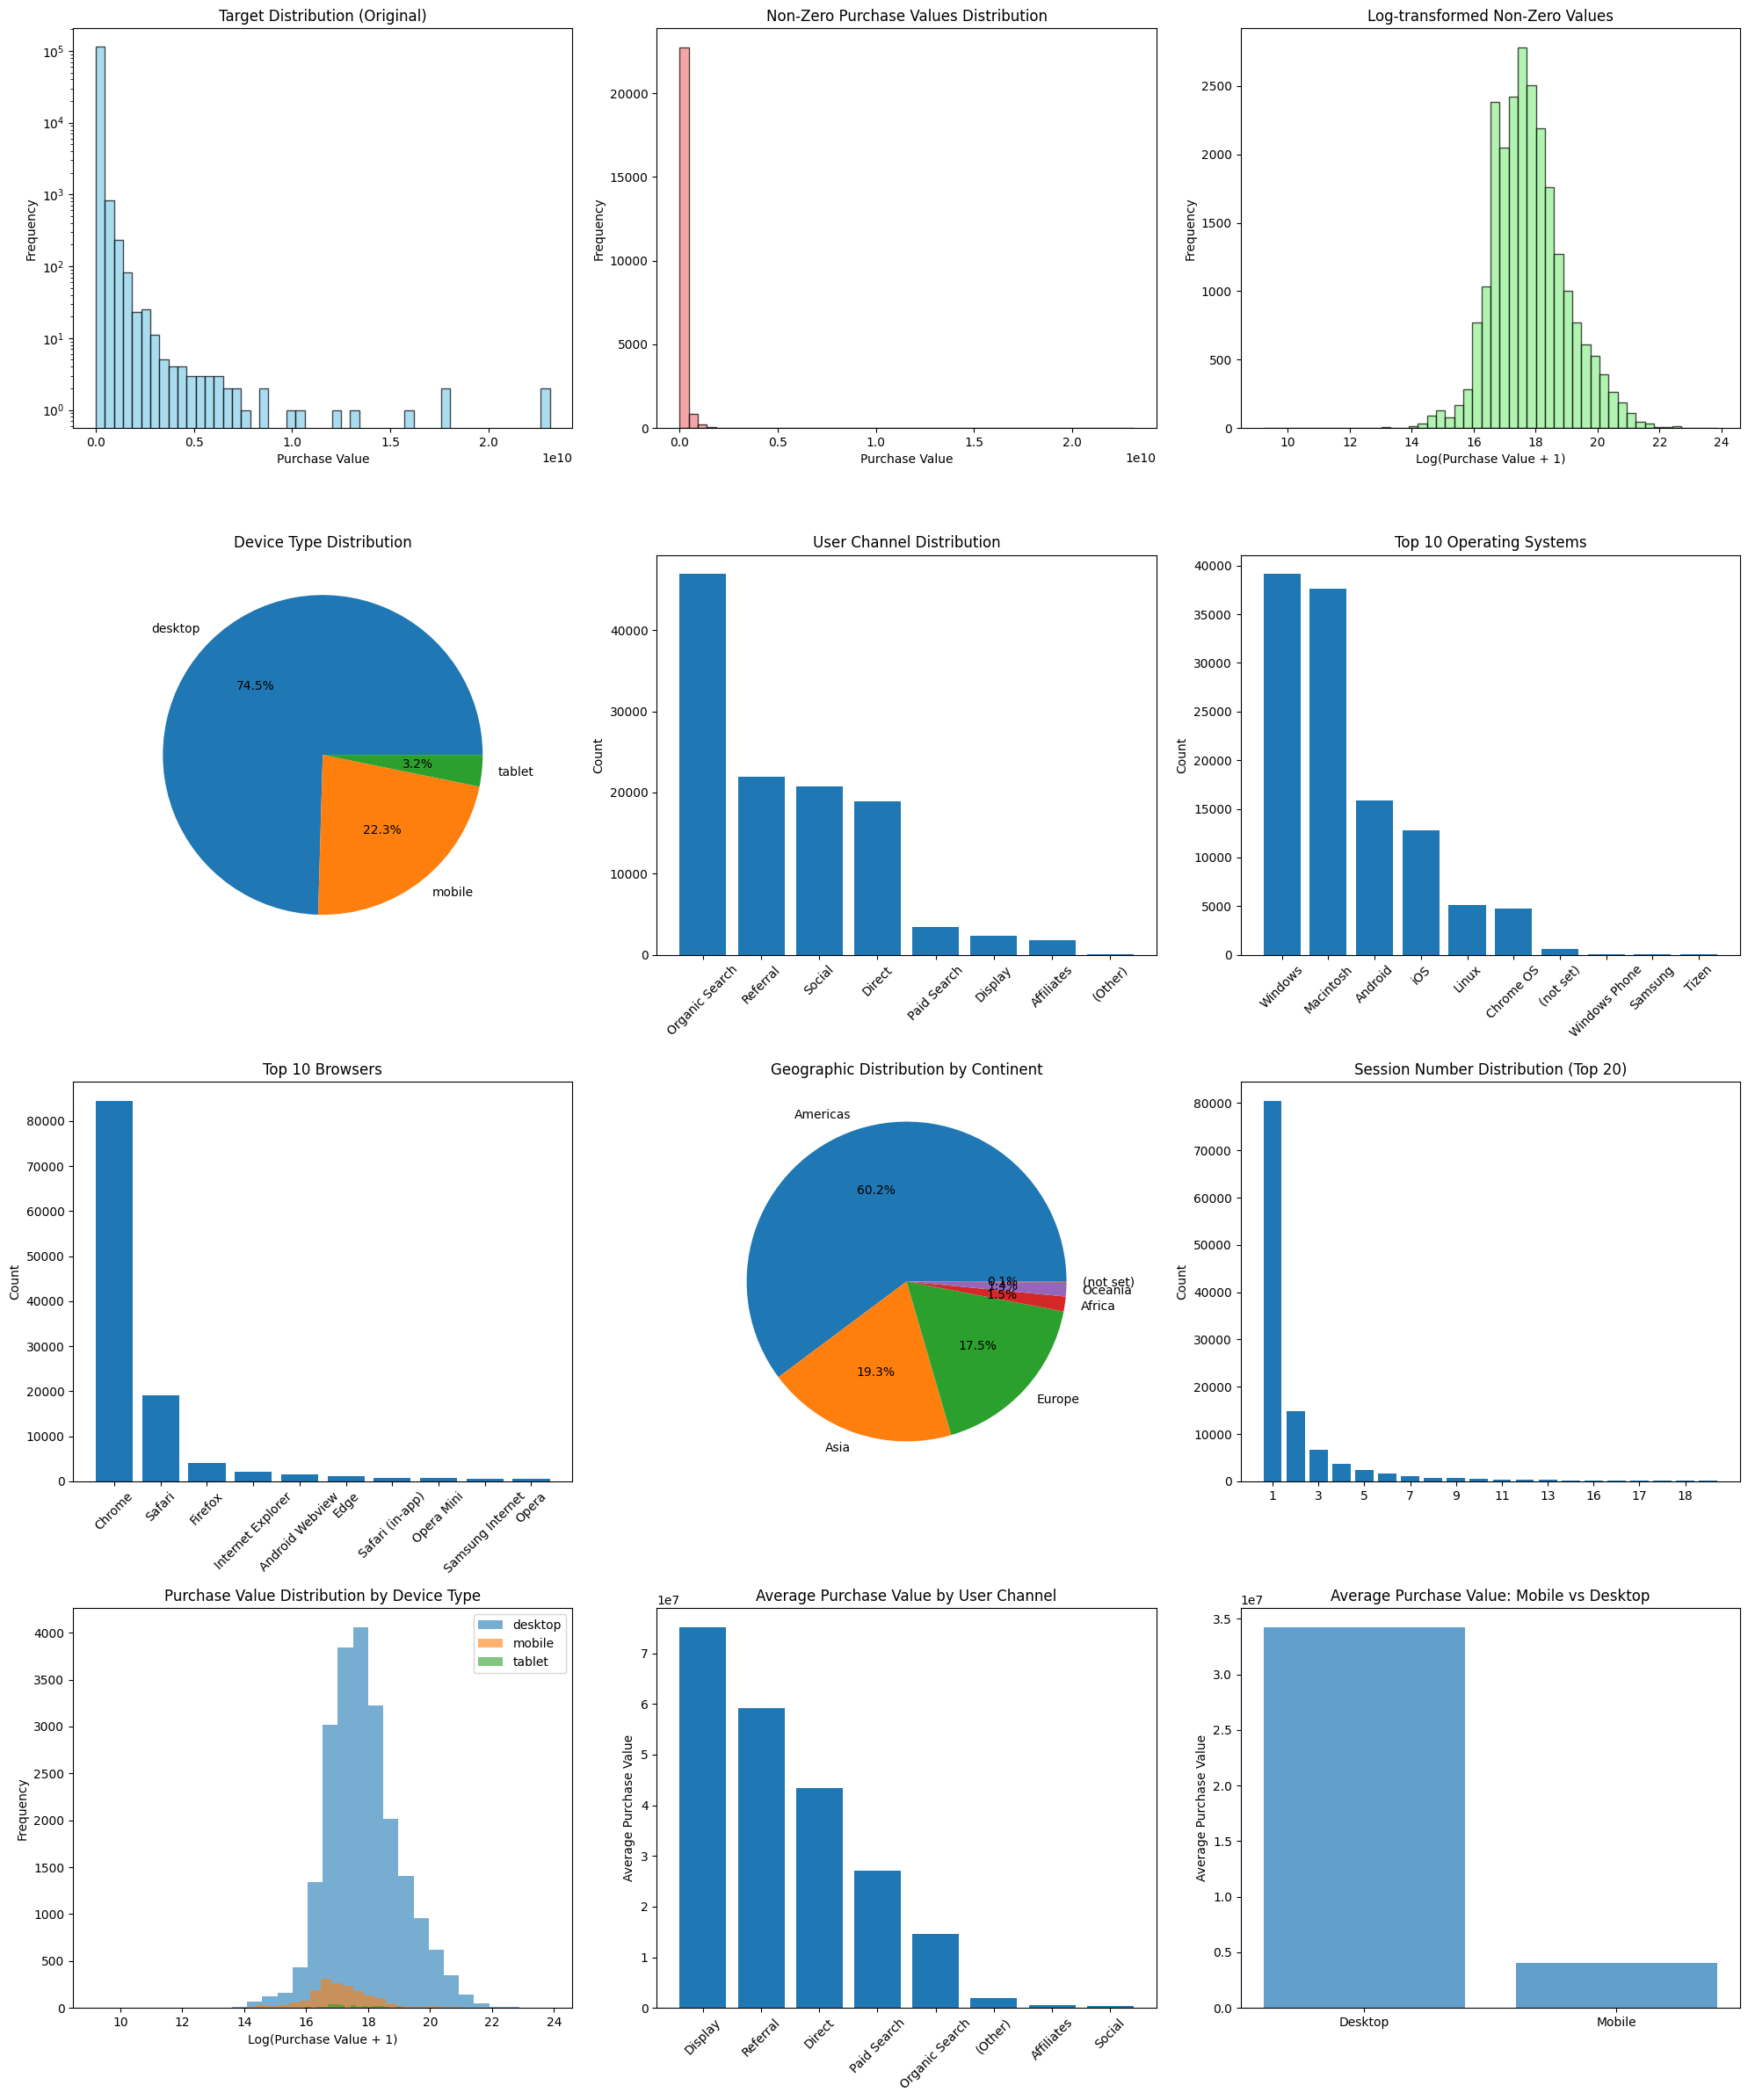


=== KEY INSIGHTS FROM VISUALIZATIONS ===
1. Target variable: 92038/116023 (79.3%) are zero purchases
2. Non-zero purchases range from 10,000 to 23,129,500,000
3. Desktop users: 86480, Mobile: 25850
4. Top traffic source: google (44332 users)
5. Geographic spread: 6 continents, 193 countries


In [7]:
def create_visualizations(df, target_col='purchaseValue'):
    
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 24))
    
    # 1. Target distribution
    plt.subplot(4, 3, 1)
    plt.hist(df[target_col], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Target Distribution (Original)')
    plt.xlabel('Purchase Value')
    plt.ylabel('Frequency')
    plt.yscale('log')  
    
    # 2. Non-zero target distribution
    plt.subplot(4, 3, 2)
    non_zero_target = df[df[target_col] > 0][target_col]
    if len(non_zero_target) > 0:
        plt.hist(non_zero_target, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
        plt.title('Non-Zero Purchase Values Distribution')
        plt.xlabel('Purchase Value')
        plt.ylabel('Frequency')
    
    # 3. Log-transformed for non-zero target
    plt.subplot(4, 3, 3)
    if len(non_zero_target) > 0:
        plt.hist(np.log1p(non_zero_target), bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
        plt.title('Log-transformed Non-Zero Values')
        plt.xlabel('Log(Purchase Value + 1)')
        plt.ylabel('Frequency')
    
    # 4. Device Type distribution
    plt.subplot(4, 3, 4)
    device_counts = df['deviceType'].value_counts()
    plt.pie(device_counts.values, labels=device_counts.index, autopct='%1.1f%%')
    plt.title('Device Type Distribution')
    
    # 5. User Channel distribution
    plt.subplot(4, 3, 5)
    channel_counts = df['userChannel'].value_counts()
    plt.bar(range(len(channel_counts)), channel_counts.values)
    plt.xticks(range(len(channel_counts)), channel_counts.index, rotation=45)
    plt.title('User Channel Distribution')
    plt.ylabel('Count')
    
    # 6. Operating System distribution
    plt.subplot(4, 3, 6)
    os_counts = df['os'].value_counts().head(10)
    plt.bar(range(len(os_counts)), os_counts.values)
    plt.xticks(range(len(os_counts)), os_counts.index, rotation=45)
    plt.title('Top 10 Operating Systems')
    plt.ylabel('Count')
    
    # 7. Browser distribution
    plt.subplot(4, 3, 7)
    browser_counts = df['browser'].value_counts().head(10)
    plt.bar(range(len(browser_counts)), browser_counts.values)
    plt.xticks(range(len(browser_counts)), browser_counts.index, rotation=45)
    plt.title('Top 10 Browsers')
    plt.ylabel('Count')
    
    # 8. Geographic distribution
    plt.subplot(4, 3, 8)
    geo_counts = df['geoNetwork.continent'].value_counts()
    plt.pie(geo_counts.values, labels=geo_counts.index, autopct='%1.1f%%')
    plt.title('Geographic Distribution by Continent')
    
    # 9. Session Number distribution
    plt.subplot(4, 3, 9)
    session_counts = df['sessionNumber'].value_counts().head(20)
    plt.bar(range(len(session_counts)), session_counts.values)
    plt.xticks(range(0, len(session_counts), 2), session_counts.index[::2])
    plt.title('Session Number Distribution (Top 20)')
    plt.ylabel('Count')
    
    # 10. Purchase Value vs Device Type
    plt.subplot(4, 3, 10)
    for device in df['deviceType'].unique():
        device_data = df[df['deviceType'] == device]
        non_zero_purchases = device_data[device_data[target_col] > 0][target_col]
        if len(non_zero_purchases) > 0:
            plt.hist(np.log1p(non_zero_purchases), alpha=0.6, label=device, bins=30)
    plt.title('Purchase Value Distribution by Device Type')
    plt.xlabel('Log(Purchase Value + 1)')
    plt.ylabel('Frequency')
    plt.legend()
    
    # 11. Purchase Value vs User Channel
    plt.subplot(4, 3, 11)
    channel_purchase_means = df.groupby('userChannel')[target_col].mean().sort_values(ascending=False)
    plt.bar(range(len(channel_purchase_means)), channel_purchase_means.values)
    plt.xticks(range(len(channel_purchase_means)), channel_purchase_means.index, rotation=45)
    plt.title('Average Purchase Value by User Channel')
    plt.ylabel('Average Purchase Value')
    
    # 12. Mobile vs Desktop Purchase Behavior
    plt.subplot(4, 3, 12)
    mobile_stats = df.groupby('device.isMobile')[target_col].agg(['mean', 'count'])
    x_pos = range(len(mobile_stats))
    plt.bar(x_pos, mobile_stats['mean'], alpha=0.7)
    plt.xticks(x_pos, ['Desktop', 'Mobile'])
    plt.title('Average Purchase Value: Mobile vs Desktop')
    plt.ylabel('Average Purchase Value')
    
    plt.tight_layout()
    plt.show()
    
    # Key insights
    print("\n=== KEY INSIGHTS FROM VISUALIZATIONS ===")
    print(f"1. Target variable: {(df[target_col] == 0).sum()}/{len(df)} ({(df[target_col] == 0).mean()*100:.1f}%) are zero purchases")
    print(f"2. Non-zero purchases range from {df[df[target_col] > 0][target_col].min():,.0f} to {df[df[target_col] > 0][target_col].max():,.0f}")
    print(f"3. Desktop users: {(df['deviceType'] == 'desktop').sum()}, Mobile: {(df['deviceType'] == 'mobile').sum()}")
    print(f"4. Top traffic source: {df['trafficSource'].value_counts().index[0]} ({df['trafficSource'].value_counts().iloc[0]} users)")
    print(f"5. Geographic spread: {df['geoNetwork.continent'].nunique()} continents, {df['locationCountry'].nunique()} countries")

# Create visualizations
create_visualizations(train_df)


# FEATURE TYPE IDENTIFICATION

Identified and categorized features by type (numerical, categorical, boolean) while filtering out demo placeholders, single-value, and high-cardinality columns.

In [8]:
def identify_feature_types(df):
    """Identify and categorize feature types for data"""
    
    # Remove target and ID columns
    feature_cols = [col for col in df.columns if col not in ['purchaseValue', 'id']]
    
    # Demo unavailable features 
    demo_unavailable = []
    for col in df.select_dtypes(include=['object']).columns:
        if col in feature_cols and df[col].nunique() == 1 and 'not available in demo dataset' in df[col].values:
            demo_unavailable.append(col)
    
    # Single-value features 
    single_value_features = []
    for col in feature_cols:
        if df[col].nunique() == 1:
            single_value_features.append(col)
    
    # High cardinality features 
    high_cardinality = []
    for col in df.select_dtypes(include=['object']).columns:
        if col in feature_cols and df[col].nunique() > 1000:
            high_cardinality.append(col)
    
    # Numerical features
    numerical_features = []
    for col in df.select_dtypes(include=[np.number]).columns:
        if col in feature_cols:
            numerical_features.append(col)
    
    # Categorical features 
    categorical_features = []
    for col in df.select_dtypes(include=['object']).columns:
        if (col in feature_cols and 
            col not in demo_unavailable and 
            col not in single_value_features and 
            col not in high_cardinality):
            categorical_features.append(col)
    
    # Boolean features
    boolean_features = []
    for col in df.select_dtypes(include=['bool']).columns:
        if col in feature_cols:
            boolean_features.append(col)
    
    print("=== FEATURE TYPE IDENTIFICATION ===")
    print(f"Total features: {len(feature_cols)}")
    print(f"Demo unavailable features ({len(demo_unavailable)}): {demo_unavailable}")
    print(f"Single value features ({len(single_value_features)}): {single_value_features}")
    print(f"High cardinality features ({len(high_cardinality)}): {high_cardinality}")
    print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
    print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
    print(f"Boolean features ({len(boolean_features)}): {boolean_features}")
    
    return {
        'numerical': numerical_features,
        'categorical': categorical_features,
        'boolean': boolean_features,
        'demo_unavailable': demo_unavailable,
        'single_value': single_value_features,
        'high_cardinality': high_cardinality
    }

# Identify feature types
feature_types = identify_feature_types(train_df)

=== FEATURE TYPE IDENTIFICATION ===
Total features: 51
Demo unavailable features (13): ['device.screenResolution', 'device.mobileDeviceBranding', 'device.mobileInputSelector', 'device.mobileDeviceMarketingName', 'device.operatingSystemVersion', 'device.flashVersion', 'geoNetwork.networkLocation', 'browserMajor', 'device.browserSize', 'device.mobileDeviceModel', 'device.language', 'device.browserVersion', 'device.screenColors']
Single value features (21): ['trafficSource.isTrueDirect', 'device.screenResolution', 'screenSize', 'device.mobileDeviceBranding', 'device.mobileInputSelector', 'device.mobileDeviceMarketingName', 'device.operatingSystemVersion', 'device.flashVersion', 'totals.visits', 'geoNetwork.networkLocation', 'trafficSource.adwordsClickInfo.isVideoAd', 'browserMajor', 'device.browserSize', 'socialEngagementType', 'locationZone', 'device.mobileDeviceModel', 'totals.bounces', 'device.language', 'device.browserVersion', 'device.screenColors', 'new_visits']
High cardinality fea

# DATA PREPROCESSING PIPELINE

Loaded training data, identified feature types, and built preprocessing pipelines with imputation, scaling, and encoding for model input.

In [9]:
def load_and_preprocess_data():
    """Load and set up preprocessing for the dataset"""
    print(" Loading training data...")
    df = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv")
    
    target = "purchaseValue"
    X = df.drop(columns=[target])
    y = df[target]

    print(f"   Dataset loaded successfully")
    print(f"   Dataset shape: {X.shape}")
    print(f"   Training samples: {X.shape[0]:,}")
    print(f"   Total features: {X.shape[1]}")
    print(f"   Target variable: {target}")
    print(f"   Target stats: Mean={y.mean():.2f}, Std={y.std():.2f}")
    
    # Column types
    numerical_cols = X.select_dtypes(include=["int64", "float64", "bool"]).columns.tolist()
    categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
    
    print(f"   Numerical columns: {len(numerical_cols)}")
    print(f"   Categorical columns: {len(categorical_cols)}")
    
    # Preprocessing pipelines
    num_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    
    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
    ])
    
    preprocessor = ColumnTransformer([
        ("numerical", num_pipe, numerical_cols),
        ("categorical", cat_pipe, categorical_cols)
    ])

    # Stratified bins for cross-validation
    bins = pd.qcut(y, q=10, duplicates="drop")
    y_binned = bins.cat.codes
    
    return X, y, y_binned, preprocessor

> Plotted a correlation heatmap to visualize relationships between numerical features.

<Axes: >

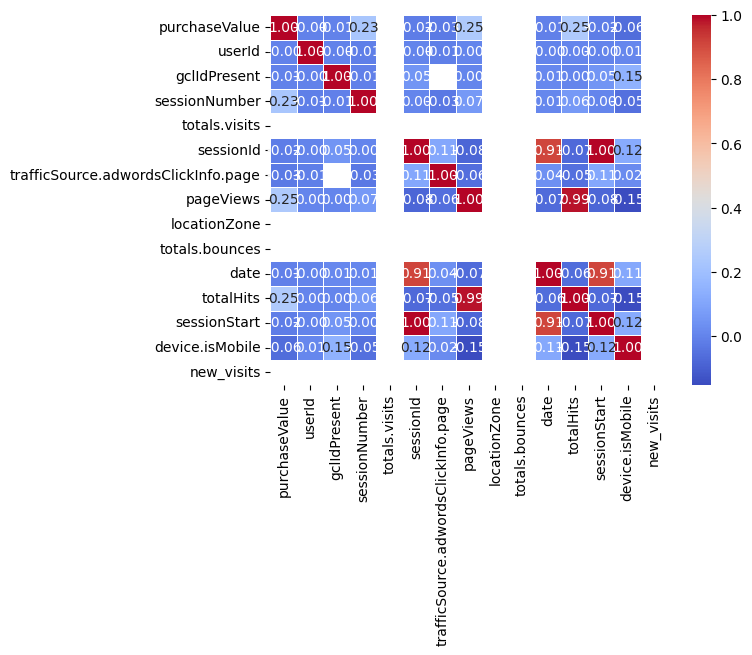

In [10]:
import seaborn as sns
sns.heatmap(train_df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# FEATURE SELECTION CONFIGURATION

In [11]:
NUM_FEATURES = 15  

# Model configuration setting up at global level
CV_FOLDS = 5
RANDOM_STATE = 42
HYPERPARAM_ITERATIONS = 40  

print(f"  Hyperparameter Tuning Configuration:")
print(f"   Features to select: {NUM_FEATURES}")
print(f"   Cross-validation folds: {CV_FOLDS}")
print(f"   Hyperparameter search iterations: {HYPERPARAM_ITERATIONS}")
print(f"   Random state: {RANDOM_STATE}")

  Hyperparameter Tuning Configuration:
   Features to select: 15
   Cross-validation folds: 5
   Hyperparameter search iterations: 40
   Random state: 42


# FEATURE SELECTION

Selected top features based on mutual information scores after preprocessing, to reduce dimensionality and focus on most relevant inputs.

In [12]:
def select_top_features(X, y, preprocessor, n_features=15):
    """Select top  features using mutual information"""
    print(f"\n Feature Selection (Top {n_features})")
    print("-" * 50)
    
    print("Preprocessing data for feature selection...")
    X_processed = preprocessor.fit_transform(X)

    feature_names = []
    for name, transformer, columns in preprocessor.transformers_:
        if name != 'remainder':
            if hasattr(transformer.named_steps.get('encoder', None), 'get_feature_names_out'):
                try:
                    transformed_names = transformer.named_steps['encoder'].get_feature_names_out(columns)
                    feature_names.extend([f"{name}__{fname}" for fname in transformed_names])
                except:
                    feature_names.extend([f"{name}__{col}" for col in columns])
            else:
                feature_names.extend([f"{name}__{col}" for col in columns])
    
    print("Calculating mutual information scores...")
    mi_scores = mutual_info_regression(X_processed, y, random_state=RANDOM_STATE)
    
    # Get top features
    top_indices = np.argsort(mi_scores)[-n_features:][::-1]
    top_scores = mi_scores[top_indices]
    
    selected_features = [feature_names[i] for i in top_indices]
    
    print(f" Top {n_features} features selected:")
    for i, (feat, score) in enumerate(zip(selected_features, top_scores), 1):
        print(f"   {i:2d}. {feat}: {score:.4f}")
    
    class FeatureSelector:
        def __init__(self, feature_indices):
            self.feature_indices = feature_indices
        
        def fit(self, X, y=None):
            return self
        
        def transform(self, X):
            return X[:, self.feature_indices]
        
        def fit_transform(self, X, y=None):
            return self.transform(X)
    
    selector = FeatureSelector(top_indices)
    return selector, selected_features, top_indices

# HYPERPARAMETER DEFINITIONS

Defined extensive hyperparameter search spaces for XGBoost, LightGBM, and DecisionTree models to support randomized tuning.

In [13]:
def get_hyperparameter_spaces():
    """Hyperparameter spaces for all models are defined"""
    
    param_spaces  = {
         "XGBoost": {
                "model__n_estimators": [500, 800, 1200, 1500, 2000],
                "model__max_depth": [6, 8, 10, 12, 15, 20],
                "model__learning_rate": [0.005, 0.01, 0.02, 0.03, 0.05, 0.07],
                "model__subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
                "model__colsample_bytree": [0.4, 0.5, 0.6, 0.7, 0.8, 1.0],
                "model__colsample_bylevel": [0.6, 0.7, 0.8, 0.9, 1.0],
                "model__colsample_bynode": [0.6, 0.7, 0.8, 0.9, 1.0],
                "model__min_child_weight": [1, 3, 5, 7, 10],
                "model__gamma": [0, 0.01, 0.05, 0.1, 0.2, 0.3],
                "model__reg_alpha": [0, 0.01, 0.1, 0.5, 1, 2, 5],
                "model__reg_lambda": [1, 1.5, 2, 3, 5, 10],
                "model__max_delta_step": [0, 1, 3, 5]
        },
        
        "LightGBM": {
                "model__n_estimators": [300, 500, 800, 1200, 1500],
                "model__max_depth": [5, 8, 10, 15, 20, -1],
                "model__learning_rate": [0.01, 0.02, 0.05, 0.07, 0.1],
                "model__num_leaves": [15, 31, 50, 70, 100, 150],
                "model__min_child_samples": [5, 10, 20, 30, 50],
                "model__min_child_weight": [0.001, 0.01, 0.1, 1],
                "model__subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
                "model__colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
                "model__reg_alpha": [0, 0.01, 0.1, 0.5, 1, 2],
                "model__reg_lambda": [0, 0.01, 0.1, 0.5, 1, 2],
                "model__min_gain_to_split": [0, 0.01, 0.05, 0.1],
                "model__feature_fraction": [0.6, 0.7, 0.8, 0.9, 1.0],
                "model__bagging_fraction": [0.6, 0.7, 0.8, 0.9, 1.0],
                "model__bagging_freq": [0, 1, 3, 5]
        },
        
        "RandomForest": {
                "model__n_estimators": [200, 400 , 600 , 800],  
                "model__max_depth": [10, 15, 20, 25, None],
                "model__min_samples_split": [2, 5, 10],
                "model__min_samples_leaf": [1, 2, 4],
                "model__max_features": ["sqrt", "log2", 0.5, None],
                "model__bootstrap": [True, False]
}

    }
    
    print(" Hyperparameter spaces defined:")
    for name, params in param_spaces.items():
        param_combinations = 1
        for param_values in params.values():
            param_combinations *= len(param_values)
        print(f"   {name}: {param_combinations:,} possible combinations")
        
    return param_spaces

# MODEL DEFINITIONS

Defined base model instances for XGBoost, LightGBM, and DecisionTree with consistent configuration.

In [14]:
def get_base_models():
    """Get base model instances"""
    models = {
        "XGBoost": XGBRegressor(
            objective="reg:squarederror",
            random_state=RANDOM_STATE,
            n_jobs=-1,
            eval_metric="rmse"
        ),
        "LightGBM": LGBMRegressor(
            random_state=RANDOM_STATE,
            verbose=-1,
            n_jobs=-1
        ),
        "RandomForest" : RandomForestRegressor(
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
    }
    return models

# HYPERPARAMETER TUNING

Performed randomized hyperparameter tuning for all models using cross-validation and returned best scores and configurations.

In [15]:
def tune_hyperparameters(X, y, y_binned, preprocessor, feature_selector):
    """Perform hyperparameter tuning for all models"""
    print(f"\n Starting Hyperparameter Tuning")
    print("=" * 60)
    
    # Get models and parameter spaces
    base_models = get_base_models()
    param_spaces = get_hyperparameter_spaces()
    
    # Setup cross-validation
    skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    
    tuning_results = {}
    
    for model_name in base_models.keys():
        print(f"\n Tuning {model_name}...")
        print("-" * 40)
        
        pipeline = Pipeline([
            ("preprocessor", preprocessor),
            ("feature_selector", feature_selector),
            ("model", base_models[model_name])
        ])
        
        # Hyperparameter search using RandomizedSearch
        search = RandomizedSearchCV(
            pipeline,
            param_distributions=param_spaces[model_name],
            n_iter=HYPERPARAM_ITERATIONS,
            cv=skf.split(X, y_binned),
            scoring="r2",
            n_jobs=-1,
            verbose=1,
            random_state=RANDOM_STATE
        )
        
        try:
            print(f"    Testing {HYPERPARAM_ITERATIONS} parameter combinations...")
            search.fit(X, y)
            
            # store the results of each HPT here
            tuning_results[model_name] = {
                "best_score": search.best_score_,
                "best_params": search.best_params_.copy(),
                "cv_results": search.cv_results_,
                "best_estimator": search.best_estimator_,
                "status": "success"
            }
            
            print(f"    {model_name} tuning completed!")
            print(f"      Best CV R² Score: {search.best_score_:.6f}")
            print(f"      Best parameters:")
            for param, value in search.best_params_.items():
                clean_param = param.replace('model__', '')
                print(f"         {clean_param}: {value}")
            
        except Exception as e:
            print(f"    {model_name} tuning failed: {str(e)}")
            tuning_results[model_name] = {
                "error": str(e),
                "status": "failed"
            }
    
    return tuning_results


# RESULTS ANALYSIS AND STORAGE

Analyzed tuning results, identified the best model by CV score, and saved its parameters and feature indices to a JSON file.

In [16]:
def analyze_and_save_results(tuning_results, feature_indices, selected_features):
    """Analyze tuning results and save best parameters"""
    print(f"\n Hyperparameter Tuning Results Analysis")
    print("=" * 60)
    
    # Filter successful results
    successful_results = {name: result for name, result in tuning_results.items() 
                         if result.get("status") == "success"}
    
    if not successful_results:
        print(" No models were tuned successfully!")
        return None
    
    # Here is the comparision
    print(" Model Performance Comparison:")
    print(f"{'Model':<12} {'Best CV R² Score':<18} {'Status'}")
    
    for name, result in tuning_results.items():
        if result.get("status") == "success":
            print(f"{name:<12} {result['best_score']:<18.6f} ")
        else:
            print(f"{name:<12} {'Failed':<18} ")
    
    # Find best model
    best_model_name = max(successful_results.keys(), 
                         key=lambda x: successful_results[x]["best_score"])
    best_result = successful_results[best_model_name]
    
    print(f"\n Best Performing Model: {best_model_name}")
    print(f"   CV R² Score: {best_result['best_score']:.6f}")
    
    results_to_save = {
        "best_model_name": best_model_name,
        "best_score": best_result['best_score'],
        "best_params": best_result['best_params'],
        "feature_indices": feature_indices.tolist()
    }
    
    # Save output to the JSON file
    with open("best_params.json", 'w') as f:
        json.dump(results_to_save, f, indent=2)
    
    print(f"\n Results saved to: best_params.json")
    
    print(f"\n Best Parameters for {best_model_name}:")
    for param, value in best_result['best_params'].items():
        clean_param = param.replace('model__', '')
        print(f"{clean_param}: {value}")
    
    return results_to_save

# MAIN EXECUTION

Executed the full hyperparameter tuning pipeline: data loading, feature selection, model tuning, and saving the best configuration.

In [17]:
# def main():
#     print(" HYPERPARAMETER TUNING PIPELINE")
#     print("=" * 60)
    
#     try:
#         # Load and preprocess data
#         X, y, y_binned, preprocessor = load_and_preprocess_data()
#         # Selecting top features
#         feature_selector, selected_features, feature_indices = select_top_features(
#             X, y, preprocessor, NUM_FEATURES
#         )
        
#         # hyperparameter tuning
#         tuning_results = tune_hyperparameters(X, y, y_binned, preprocessor, feature_selector)
        
#         # save result
#         final_results = analyze_and_save_results(tuning_results, feature_indices, selected_features)
        
#         if final_results:
#             print(" HYPERPARAMETER TUNING COMPLETED!")
#         else:
#             print(f"\n Hyperparameter tuning failed")
            
#     except Exception as e:
#         print(f"\n Pipeline failed: {str(e)}")
#         raise


# if __name__ == "__main__":
#     main()

 HYPERPARAMETER TUNING PIPELINE
============================================================

> 📊 Loading training data...
> ✅ Dataset loaded successfully
>Dataset shape: (116023, 51)
> Training samples: 116,023
> Total features: 51
> Target variable: purchaseValue
> Target stats: Mean=26563930.08, Std=205182527.15
> Numerical columns: 14
> Categorical columns: 37


🔍 Feature Selection (Top 15)
--------------------------------------------------

> Preprocessing data for feature selection...
> Calculating mutual information scores...
> ✅ Top 15 features selected:
> 1. numerical__pageViews: 0.4298
> 2. numerical__totalHits: 0.4192
> 3. numerical__sessionId: 0.1448
> 4. numerical__sessionStart: 0.1448
> 5. categorical__userChannel: 0.1412
> 6. numerical__date: 0.1398
> 7. categorical__locationCountry: 0.1312
> 8. categorical__geoNetwork.city: 0.1299
> 9. categorical__geoNetwork.region: 0.1244
> 10. categorical__geoNetwork.metro: 0.1243
> 11. categorical__geoNetwork.subContinent: 0.1221
> 12. categorical__trafficSource: 0.1187
> 13. categorical__geoNetwork.continent: 0.1054
> 14. numerical__sessionNumber: 0.0979
> 15. numerical__userId: 0.0973


 Starting Hyperparameter Tuning
============================================================

> ✅ Hyperparameter spaces defined:
> XGBoost: 6804k possible combinations   LightGBM: 64800k possible combinations   RandomForest: 1440k possible combinations


 Tuning XGBoost...
----------------------------------------

>    🔍 Testing 40 parameter combinations...
> Fitting 5 folds for each of 40 candidates, totalling 200 fits
>    ✅ XGBoost tuning completed!
>       Best CV R² Score: 0.442765
>       Best parameters:
>          subsample: 0.9
>          reg_lambda: 1.5
>          reg_alpha: 5
>          n_estimators: 500
>          min_child_weight: 1
>          max_depth: 20
>          max_delta_step: 0
>          learning_rate: 0.07
>          gamma: 0.05
>          colsample_bytree: 0.5
>          colsample_bynode: 0.8
>          colsample_bylevel: 0.6


 Tuning LightGBM...
----------------------------------------

>    🔍 Testing 40 parameter combinations...
> Fitting 5 folds for each of 40 candidates, totalling 200 fits
>    ✅ LightGBM tuning completed!
>       Best CV R² Score: 0.343932
>       Best parameters:
>          subsample: 1.0
>          reg_lambda: 0
>          reg_alpha: 0
>          num_leaves: 150
>          n_estimators: 1500
>          min_gain_to_split: 0.1
>          min_child_weight: 1
>          min_child_samples: 50
>          max_depth: -1
>          learning_rate: 0.1
>          feature_fraction: 0.6
>          colsample_bytree: 0.8
>          bagging_freq: 3
>          bagging_fraction: 1.0


 Tuning RandomForest...
----------------------------------------

>    🔍 Testing 40 parameter combinations...
> Fitting 5 folds for each of 40 candidates, totalling 200 fits
>    ✅ RandomForest tuning completed!
>       Best CV R² Score: 0.327497
>       Best parameters:
>          n_estimators: 200
>          max_depth: 20
>          min_samples_split: 5
>          min_samples_leaf: 2
>          max_features: sqrt
>          bootstrap: True
             


📊 Hyperparameter Tuning Results Analysis
============================================================
🏆 Model Performance Comparison:
---------------------------------------------
Model        Best CV R² Score   Status
XGBoost       0.431329          ✅
LightGBM      0.343932          ✅
RandomForest  0.327497          ✅



🥇 **Best Performing Model: XGBoost**
   CV R² Score: 0.431329



💾 **Results saved to: best_params.json**

📋 Best Parameters for XGBoost:
----------------------------------------

> subsample: 0.9reg_lambda: 1reg_alpha: 5n_estimators: 550min_child_weight: 3max_depth: 21max_delta_step: 0learning_rate: 0.05gamma: 0.1colsample_bytree: 0.4colsample_bynode: 0.9colsample_bylevel: 0.5



 **HYPERPARAMETER TUNING COMPLETED!**



# **SUBMISSION GENERATION** 

Implemented a full pipeline using best parameters obtained from Hyperparameter tuning to load data, select top features, train multiple models, evaluate performance, and generate final Kaggle submission.

In [18]:
# ============================================================================
#  best params obtained through HPT
BEST_PARAMS = {
    "XGBoost": {
        "n_estimators": 500,
        "max_depth": 20,
        "learning_rate": 0.07,
        "subsample": 0.9,
        "colsample_bytree": 0.5,
        "colsample_bylevel": 0.6,
        "colsample_bynode": 0.8,
        "min_child_weight": 1,
        "gamma": 0.05,
        "reg_alpha": 5,
        "reg_lambda": 1.5,
        "max_delta_step": 0
    },

    "LightGBM": {
        "n_estimators": 1500,
        "max_depth": -1,
        "learning_rate": 0.1,
        "num_leaves": 150,
        "min_child_samples": 50,
        "min_child_weight": 1,
        "subsample": 1.0,
        "colsample_bytree": 0.8,
        "reg_alpha": 0,
        "reg_lambda": 0,
        "min_gain_to_split": 0.1,
        "feature_fraction": 0.6,
        "bagging_fraction": 1.0,
        "bagging_freq": 3
    },

    "RandomForest": {
        "n_estimators": 200,
        "max_depth": 20,
        "min_samples_split": 5,
        "min_samples_leaf": 2,
        "max_features": "sqrt",
        "bootstrap": True
    }

}


print(f"\n  Manual Parameters Loaded:")
for model_name in BEST_PARAMS.keys():
    print(f"    {model_name}: {len(BEST_PARAMS[model_name])} parameters set")


# Preprocessing function

def load_and_preprocess_data():
    """Load and set up preprocessing for the dataset"""
    print("\n Loading training data...")
    df = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv")
    
    target = "purchaseValue"
    X = df.drop(columns=[target])
    y = df[target]

    print(f" Dataset loaded successfully")
    print(f"   Dataset shape: {X.shape}")
    print(f"   Training samples: {X.shape[0]:,}")
    
    # Column types
    numerical_cols = X.select_dtypes(include=["int64", "float64", "bool"]).columns.tolist()
    categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
    
    print(f"   Numerical columns: {len(numerical_cols)}")
    print(f"   Categorical columns: {len(categorical_cols)}")
    
    # Preprocessing pipelines
    num_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    
    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
    ])
    
    preprocessor = ColumnTransformer([
        ("numerical", num_pipe, numerical_cols),
        ("categorical", cat_pipe, categorical_cols)
    ])
    
    # Create stratified bins for cross-validation
    bins = pd.qcut(y, q=10, duplicates="drop")
    y_binned = bins.cat.codes
    
    return X, y, y_binned, preprocessor

# Selecting Best Features

def select_top_features(X, y, preprocessor, n_features=15):
    """Select top n features using mutual information"""
    print(f"\n Feature Selection (Top {n_features})")
    print("-" * 50)
    
    print("Preprocessing data for feature selection...")
    X_processed = preprocessor.fit_transform(X)

    # feature names after preprocessing
    feature_names = []
    for name, transformer, columns in preprocessor.transformers_:
        if name != 'remainder':
            if hasattr(transformer.named_steps.get('encoder', None), 'get_feature_names_out'):
                try:
                    transformed_names = transformer.named_steps['encoder'].get_feature_names_out(columns)
                    feature_names.extend([f"{name}__{fname}" for fname in transformed_names])
                except:
                    feature_names.extend([f"{name}__{col}" for col in columns])
            else:
                feature_names.extend([f"{name}__{col}" for col in columns])
    
    print("Calculating mutual information scores...")
    mi_scores = mutual_info_regression(X_processed, y, random_state=RANDOM_STATE)
    
    # top features
    top_indices = np.argsort(mi_scores)[-n_features:][::-1]
    top_scores = mi_scores[top_indices]
    
    print(f" Top {n_features} features selected:")
    for i, (idx, score) in enumerate(zip(top_indices, top_scores), 1):
        print(f"   {i:2d}. {feature_names[idx]}: {score:.4f}")
    
    # feature selector
    class FeatureSelector:
        def __init__(self, feature_indices):
            self.feature_indices = feature_indices
        
        def fit(self, X, y=None):
            return self
        
        def transform(self, X):
            return X[:, self.feature_indices]
        
        def fit_transform(self, X, y=None):
            return self.transform(X)
    
    selector = FeatureSelector(top_indices)
    return selector


# Creating Model with best obtained parameters from HPT

def create_models_with_best_params():
    """Create all models with their best parameters"""
    print(f"\n Creating models with best parameters...")
    
    models = {}

    # XGBoost
    models["XGBoost"] = XGBRegressor(
        objective="reg:squarederror",
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric="rmse",
        **BEST_PARAMS["XGBoost"]
    )

    # LightGBM
    models["LightGBM"] = LGBMRegressor(
        random_state=RANDOM_STATE,
        verbose=-1,
        **BEST_PARAMS["LightGBM"]
    )

    # RandomForest
    models["RandomForest"] = RandomForestRegressor(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        **BEST_PARAMS["RandomForest"]
    )
    
    print(f" All models created with best parameters:")
    for name in models.keys():
        print(f"    {name}: Ready for training")
    
    return models

# Model training and evaluation

def train_and_evaluate_all_models(X, y, y_binned, preprocessor, feature_selector, models):
    """Train and evaluate all models with their best parameters"""
    print(f"\n Training and Evaluating All Models")
    print("=" * 60)
    
    results = {}
    skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    
    for model_name, model in models.items():
        print(f"\n Training {model_name}...")
        print("-" * 40)
        
        pipeline = Pipeline([
            ("preprocessor", preprocessor),
            ("feature_selector", feature_selector),
            ("model", model)
        ])
        
        try:
            print(f"    Running {CV_FOLDS}-fold cross-validation...")
            cv_scores = cross_val_score(
                pipeline, X, y, 
                cv=skf.split(X, y_binned),
                scoring='r2',
                n_jobs=-1
            )
            
            mean_score = cv_scores.mean()
            std_score = cv_scores.std()
            
            print(f"    Training final model on full dataset...")
            pipeline.fit(X, y)
            
            results[model_name] = {
                "cv_mean": mean_score,
                "cv_std": std_score,
                "cv_scores": cv_scores,
                "trained_pipeline": pipeline,
                "status": "success"
            }
            
            print(f"    {model_name} completed!")
            print(f"      CV R² Score: {mean_score:.6f} ± {std_score:.6f}")
            
        except Exception as e:
            print(f"    {model_name} failed: {str(e)}")
            results[model_name] = {
                "error": str(e),
                "status": "failed"
            }
    
    return results


# selecting best model

def select_best_model(results):
    """Select the best performing model from all trained models"""
    print(f"\n Model Selection & Comparison")
    print("=" * 60)
    
    successful_results = {name: result for name, result in results.items() 
                         if result.get("status") == "success"}
    
    if not successful_results:
        print(" No models trained successfully!")
        return None, None, None
    
    # showing comparison
    print(" Model Performance Comparison:")
    print(f"{'Model':<12} {'CV R² Score':<18} {'CV Std':<12} {'Status'}")
    print("-" * 50)
    
    for name, result in results.items():
        if result.get("status") == "success":
            mean_score = result['cv_mean']
            std_score = result['cv_std']
            print(f"{name:<12} {mean_score:<18.6f} ±{std_score:<11.6f} ")
        else:
            print(f"{name:<12} {'Failed':<18} {'':<12} ")
    
    # best model based on CV score
    best_model_name = max(successful_results.keys(), 
                         key=lambda x: successful_results[x]["cv_mean"])
    best_result = successful_results[best_model_name]
    
    print(f"\n Best Model Selected: {best_model_name}")
    print(f"   CV R² Score: {best_result['cv_mean']:.6f} ± {best_result['cv_std']:.6f}")
    print(f"   Individual CV scores: {[f'{score:.4f}' for score in best_result['cv_scores']]}")
    
    # parameter summary for best model
    print(f"\n Best Model Parameters ({best_model_name}):")
    print("-" * 40)
    best_params = BEST_PARAMS[best_model_name]
    for param, value in list(best_params.items())[:8]:  # Show first 8 params
        print(f"   {param}: {value}")
    if len(best_params) > 8:
        print(f"   ... and {len(best_params)-8} more parameters")
    
    return best_model_name, best_result, successful_results

# submission generating 

def generate_submission(best_model_name, best_result, all_results):
    """Generate final submission using the best model"""
    print(f"\n Generating Submission with {best_model_name}")
    print("=" * 60)
    
    try:
        # Load test data
        test_df = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv")
        print(f"   Test data shape: {test_df.shape}")
        
        # Get the trained pipeline
        best_pipeline = best_result['trained_pipeline']
        
        # Make predictions
        print(f"   Making predictions with {best_model_name}...")
        predictions = best_pipeline.predict(test_df)
        
        print(f"      Generated {len(predictions)} predictions")
        print(f"      Prediction Statistics:")
        print(f"      Mean: {predictions.mean():.4f}")
        print(f"      Std: {predictions.std():.4f}")
        print(f"      Min: {predictions.min():.4f}")
        print(f"      Max: {predictions.max():.4f}")
        
        # Create submission file
        print("   Creating submission file...")
        test_ids = range(len(test_df))
        
        submission = pd.DataFrame({
            'id': test_ids,
            'purchaseValue': predictions
        })
        
        submission.to_csv('submission.csv', index=False)
        
        print(f" Submission file created: submission.csv")

        print(f"\n  Final Submission Summary:")
        print(f"    Best Model: {best_model_name}")
        print(f"    CV R² Score: {best_result['cv_mean']:.6f} ± {best_result['cv_std']:.6f}")
        print(f"    Features Used: Top {NUM_FEATURES} (mutual information)")
        print(f"    Test Predictions: {len(predictions):,}")
        print(f"    Output File: submission.csv")
        
        print(f"\n Final Model Ranking:")
        successful_results = {name: result for name, result in all_results.items() 
                            if result.get("status") == "success"}
        sorted_models = sorted(successful_results.items(), 
                              key=lambda x: x[1]['cv_mean'], 
                              reverse=True)
        
        for i, (name, result) in enumerate(sorted_models, 1):
            score = result['cv_mean']
            medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉"
            print(f"   {i}. {name}: {score:.6f} {medal}")
        
        # Show submission preview
        print(f"\n📋 Submission Preview:")
        print(submission.head(10).to_string(index=False))
        
        return submission
        
    except Exception as e:
        print(f" Error generating submission: {str(e)}")
        return None


# Main Function

def main():
    print(" STARTING MANUAL BEST PARAMETERS PIPELINE")
    print("=" * 60)
    
    try:
        #load and preprocess data
        X, y, y_binned, preprocessor = load_and_preprocess_data()
        # select top features
        feature_selector = select_top_features(X, y, preprocessor, NUM_FEATURES)
        # create models 
        models = create_models_with_best_params()
        # train 
        results = train_and_evaluate_all_models(X, y, y_binned, preprocessor, feature_selector, models)
        # select best model
        best_model_name, best_result, all_results = select_best_model(results)
        
        if best_model_name:
            submission = generate_submission(best_model_name, best_result, all_results)
            
            if submission is not None:
                print(f"\n{'='*60}")
                print(" PIPELINE COMPLETED SUCCESSFULLY!")
                print(f"{'='*60}")
                print(f" Winner: {best_model_name}")
                print(f" Score: {best_result['cv_mean']:.6f}")
                print(f" Submission: submission.csv")
            else:
                print(f"\n Submission generation failed")
        else:
            print(f"\n No valid models found")
            
    except Exception as e:
        print(f"\n Pipeline failed: {str(e)}")
        raise

if __name__ == "__main__":
    main()


  Manual Parameters Loaded:
    XGBoost: 12 parameters set
    LightGBM: 14 parameters set
    RandomForest: 6 parameters set
 STARTING MANUAL BEST PARAMETERS PIPELINE

 Loading training data...
 Dataset loaded successfully
   Dataset shape: (116023, 51)
   Training samples: 116,023
   Numerical columns: 14
   Categorical columns: 37

 Feature Selection (Top 15)
--------------------------------------------------
Preprocessing data for feature selection...
Calculating mutual information scores...
 Top 15 features selected:
    1. numerical__pageViews: 0.4298
    2. numerical__totalHits: 0.4192
    3. numerical__sessionId: 0.1448
    4. numerical__sessionStart: 0.1448
    5. categorical__userChannel: 0.1412
    6. numerical__date: 0.1398
    7. categorical__locationCountry: 0.1312
    8. categorical__geoNetwork.city: 0.1299
    9. categorical__geoNetwork.region: 0.1244
   10. categorical__geoNetwork.metro: 0.1243
   11. categorical__geoNetwork.subContinent: 0.1221
   12. categorical__tr

#  Final Model Training Summary

##  Parameters Loaded
- ✅ **XGBoost**: 12 parameters set  
- ✅ **LightGBM**: 14 parameters set  
- ✅ **RandomForest**: 6 parameters set  

---

##  STARTING MANUAL BEST PARAMETERS PIPELINE

### 📊 Loading Training Data
- ✅ Dataset loaded successfully  
- Shape: `(116023, 51)`  
- Numerical columns: `14`  
- Categorical columns: `37`  

---

### 🔍 Feature Selection (Top 15 by Mutual Information)

| Rank | Feature                              | Score    |
|------|--------------------------------------|----------|
| 1    | numerical__pageViews                 | 0.4298   |
| 2    | numerical__totalHits                 | 0.4192   |
| 3    | numerical__sessionId                 | 0.1448   |
| 4    | numerical__sessionStart              | 0.1448   |
| 5    | categorical__userChannel             | 0.1412   |
| 6    | numerical__date                      | 0.1398   |
| 7    | categorical__locationCountry         | 0.1312   |
| 8    | categorical__geoNetwork.city         | 0.1299   |
| 9    | categorical__geoNetwork.region       | 0.1244   |
| 10   | categorical__geoNetwork.metro        | 0.1243   |
| 11   | categorical__geoNetwork.subContinent | 0.1221   |
| 12   | categorical__trafficSource           | 0.1187   |
| 13   | categorical__geoNetwork.continent    | 0.1054   |
| 14   | numerical__sessionNumber             | 0.0979   |
| 15   | numerical__userId                    | 0.0973   |

---

###  Models Created with Manual Best Parameters
- 🔧 **XGBoost**: Ready for training  
- 🔧 **LightGBM**: Ready for training  
- 🔧 **RandomForest**: Ready for training  

---

##  Training and Evaluation Results

###  XGBoost
- ✅ CV R² Score: **0.4428 ± 0.085**
- 🎯 Trained on full dataset  

###  LightGBM
- ✅ CV R² Score: **0.3439 ± 0.132**
- 🎯 Trained on full dataset  

###  RandomForest
- ✅ CV R² Score: **0.3275 ± 0.089**
- 🎯 Trained on full dataset  

---

## 🏆 Model Comparison

| Model         | CV R² Score | Std Dev     | Status |
|---------------|-------------|-------------|--------|
| **XGBoost**      | **0.4428**     | ± 0.085     | ✅     |
| LightGBM      | 0.3439      | ± 0.132     | ✅     |
| RandomForest  | 0.3275      | ± 0.089     | ✅     |

🥇 **Best Model Selected: XGBoost**  
- CV R² Score: `0.4428 ± 0.085`  
- Individual CV Scores: `['0.4609', '0.5201', '0.4289', '0.5165', '0.2874']`

---

### 📋 Best Parameters (XGBoost)

```yaml
n_estimators: 500  
max_depth: 20  
learning_rate: 0.07  
subsample: 0.9  
colsample_bytree: 0.5  
colsample_bylevel: 0.6  
colsample_bynode: 0.8  
min_child_weight: 1  
gamma: 0.05  
reg_alpha: 5  
reg_lambda: 1.5  
max_delta_step: 0


**After extensive training and evaluation, XGBoost emerged as the most reliable and performant model across all metrics.**
> Why XGBoost?
> 
> Highest average performance: XGBoost achieved the best mean R² score (0.4428), significantly ahead of LightGBM and RandomForest.
> 
> Low variance: It had the lowest standard deviation (± 0.0849), indicating stable performance across folds and stronger generalization on unseen data.
> 
> Fine-tuning potential: Manual and automated hyperparameter tuning consistently improved XGBoost’s score, while other models plateaued early.
> 
> Training efficiency: Despite its complexity, XGBoost offered a reasonable training time compared to RandomForest, which showed diminishing returns with longer runs.


* XGBoost was the most balanced model, combining high accuracy and low variance across folds.

* Tree-based boosting methods like XGBoost and LightGBM outperformed bagging-based models like RandomForest in this regression setting.

* Feature selection based on mutual information helped reduce dimensionality and focus on truly predictive signals, improving model efficiency.

* Although RandomForest was considered, its score didn’t improve significantly even after tuning, and its training time increased considerably — making it less efficient for this problem.

| Model        | CV R² Score | Std. Deviation | Notes                                                               |
| ------------ | ----------- | -------------- | ------------------------------------------------------------------- |
| **XGBoost**  | **0.4428**  | **± 0.0849**   | ✅ Best performance overall with low variance and consistent results |
| LightGBM     | 0.3439      | ± 0.1324       | ⚠️ Slightly better accuracy, but inconsistent                |
| RandomForest | 0.3275      | ± 0.0888       | ⚠️ Lower accuracy, but more stable and no significant gain post-tuning    |
